In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
import os
os.getcwd()
os.chdir('C:\\Users\\amulya\\Desktop\\Udacity\\Term1\\Project5\\ProjectSubmission')
os.getcwd()

'C:\\Users\\amulya\\Desktop\\Udacity\\Term1\\Project5\\ProjectSubmission'

## Functions for feature extraction , modelling , vehicle tracking


In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    """
    Function to compute hog features and perform visualisation
    """
    # Call with 2 outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Else call the 1 output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
    return features

In [4]:
def bin_spatial(img, size=(32, 32)):
    """
    Function to perform spatial binning on the image
    """
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

In [5]:
def color_hist(img, nbins=32):  # Note : bins_range=(0, 256) from lecture will not work
    """
    Function to compute color histogram features
    """
    # Compute the histogram of the colour channesl separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Function to extract features from a list of images
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each image, one by one
        image = mpimg.imread(file)
        # Apply colour conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor((image, cv2.COLOR_RGB2HSV))
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor((image, cv2.COLOR_RGB2LUV))
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor((image, cv2.COLOR_RGB2HLS))
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor((image, cv2.COLOR_RGB2YUV))
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                # print('converting to YCrCb')
        else:
            feature_image = np.copy(image)

        # 3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                # hog_features = np.concatenate(hog_features)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Function that takes an image, start and stop positions in both x and y, 
    window size (x and y dimensions), 
    and overlap fraction (for both x and y),
    and creates a list of windows to be searched on, for a given image
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Function that takes an image, a list of bounding boxes 
    and an optional color tuple and line thickness as inputs
    then draw boxes in that color on the output
    """
    # make a copy of the image
    imcopy = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return imcopy

In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    """
    Function to extract features from a single image window,
    This function is very similar to extract_features(),
    just for a single image rather than list of images
    
    """
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply colour conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor((img, cv2.COLOR_RGB2HSV))
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor((img, cv2.COLOR_RGB2LUV))
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor((img, cv2.COLOR_RGB2HLS))
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor((img, cv2.COLOR_RGB2YUV))
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            # print('converting to YCrCb')
    else:
        feature_image = np.copy(img)

    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
            # hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                           pix_per_cell, cell_per_block, vis=True,
                                                           feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    """
    Function to pass an image
    and the list of windows to be searched (output of slide_windows())
    """
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image and resize to the same size as used in Training cutouts
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier using scaler that we fit using the Training data
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Function for various cv2 image space conversions
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [12]:
def find_cars(img, scale):
    """
    Function that can extract features using hog sub-sampling and make predictions
    """
    img_boxes = []  # Clears img_boxes so we don't keep unwanted heatmap history
    count = 0
    draw_img = np.copy(img)

    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale != 1:  # resize whole image instead of separate windows
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    # These hold the number of HOG cells
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1  # Note : '//' causes integers to be result, instead of floats
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    # How many features per block are we going to be extracting
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    # aka 75% overlap between cells
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get colour features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict((test_features))

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255))
                img_boxes.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1

    return draw_img, img_boxes, heatmap

In [13]:
def apply_threshold(heatmap, threshold):
    """
    Function to remove false-positive detections by replacing pixel values with 0 if fall below threshold
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [14]:
def draw_labeled_bboxes(img, labels):
    """
    Function to draw bounding box around detected cars in image.
    """
    # Iterate through all detected cards
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [15]:
def add_heat(heatmap, bbox_list):
    """
    Function to create heatmap in bounding boxes
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap



In [16]:
def VideoPipeline(img):
    """
    Function for video stream of frames
    """
    avg_heat=np.zeros_like(img[:, :, 0]).astype(np.float)
    #avg_heat=np.zeros_like(image[:, :, 0]).astype(np.float)
    out_img, out_boxes, heat_map = find_cars(img, scale)

    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    #heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, out_boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # heat = apply_threshold(heat, 2)

    avg_heat = cv2.addWeighted(avg_heat, 0.8, heat, 0.2, 0.)

    # Apply threshold to help remove near-zero noise
    heatmap = apply_threshold(cv2.blur(avg_heat, (15, 15)), 0.5)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heatmap, 0, 255)  # limit the values in the heatmap array

    # Find final boxes from heatmap using label function
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    output_img = draw_labeled_bboxes(np.copy(img), labels)

    r = 377.0 / avg_heat.shape[1]  # calculate height
    dim = (377, int(avg_heat.shape[0] * r))  # width, height
    resized = cv2.resize(avg_heat, dim, interpolation=cv2.INTER_AREA)
    # add to output_img
    output_img[0:0 + resized.shape[0], 0:0 + resized.shape[1]] = np.repeat(resized[:, :, np.newaxis], 3,
                                                                         axis=2) * 255
    output_img = cv2.putText(output_img, "Heatmap", (34, 34), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2,
                           cv2.LINE_AA)

    return output_img


In [17]:
def visualise(rows, cols, imgs, titles):
    """
    Function to plot multiple images
    """
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [18]:
import glob
vehicle_loc = 'vehicles\\'
non_loc='non-vehicles\\'

cars = glob.glob(vehicle_loc + '**\\*.png', recursive=True)
notcars = glob.glob(non_loc + '**\\*.png', recursive=True)

# Feature Parameters
color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientation angles
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0  # aka 1st feature channel. Can be 0, 1, 2, or "ALL"
# hog_channel = "ALL"  # aka 1st feature channel. Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True # HOG features on or off

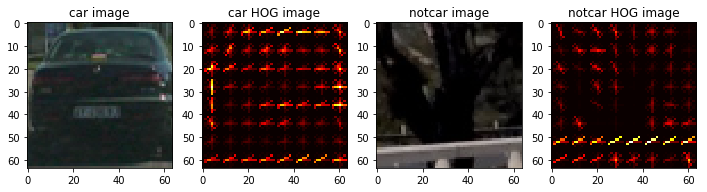

In [19]:
# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                                                  hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                  vis=True)


notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                  hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                  vis=True)

images=[car_image, car_hog_image, notcar_image, notcar_hog_image]
titles=['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualise(1, 4, images, titles)

In [ ]:
t=time.time()

# Define feature parameters
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# Train 1 RGB, orient=6, hog_channel=0, spatial_size=(16, 16), hist_bins=16 : Test Accuracy == 0.97
# Train 2 YCrCb, orient=6, hog_channel=0, spatial_size=(16, 16), hist_bins=16 : Test Accuracy == 0.96
# Train 3 YCrCb, orient=9, hog_channel=0, spatial_size=(16, 16), hist_bins=16 : Test Accuracy == 0.975
# Train 4 YCrCb, orient=9, hog_channel="ALL", spatial_size=(16, 16), hist_bins=16 : Test Accuracy == 0.985
# Train 5 YCrCb, orient=9, hog_channel="ALL", spatial_size=(32, 32), hist_bins=32 : Test Accuracy == 0.995
orient = 9  # HOG orientation angles
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"  # aka 1st feature channel. Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, 'Seconds to compute features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomised training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.5, random_state=rand_state)

svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)

print(round(time.time() - t, 2), 'Seconds to train SVC')

333.1298415660858 Seconds to compute features


In [ ]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
dist_pickle = {}
dist_pickle['svc'] = svc
dist_pickle['X_scaler'] = X_scaler
dist_pickle['orient'] = orient
dist_pickle['pix_per_cell'] = pix_per_cell
dist_pickle['cell_per_block'] = cell_per_block
dist_pickle['spatial_size'] = spatial_size
dist_pickle['hist_bins'] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", "wb"))


In [ ]:
test_images_path='test_images\\*'
example_images=glob.glob(test_images_path)

images = []
titles = []

y_start_stop = [400, 656]  # Min and max in y to search in slide_window(). Trees tops caused false positives
overlap = 0.5  # 50% overlap
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255  # IMPORTANT : reading *.jpeg's (scaled 0-255), but trained on *.png's (scaled 0-1)
    print(np.min(img), np.max(img))

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(96, 96), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                                 hog_feat=hog_feat)

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')

fig = plt.figure(figsize=(12, 18), dpi=300)
visualise(5, 2, images, titles)


In [ ]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

# Consider a narrower swath in y
ystart = 400
ystop = 656
# scale = 1  # scale entire image, apply HOG to entire image
scale = 1.5

# Iterate over test images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)

    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale != 1:  # resize whole image instead of separate windows
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    # These hold the number of HOG cells
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1  # Note : '//' causes integers to be result, instead of floats
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    # How many features per block are we going to be extracting
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    # aka 75% overlap between cells
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get colour features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict((test_features))

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255))
                img_boxes.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1

    print(time.time() - t, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])

    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(12, 24))
visualise(6, 2, out_images, out_titles)

In [ ]:
# Set Region Of Interest and Scale window inspection technique.
ystart = 400
ystop = 656
scale = 1.5

# Load Linear SVC Classifier
dist_pickle = pickle.load(open("svc_pickle.p", "rb"))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


In [ ]:
out_images = []
out_maps = []
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, out_boxes, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualise(8, 2, out_images, out_titles)

# save pickle
dist_pickle = out_boxes
pickle.dump( dist_pickle, open("bbox_pickle.p", "wb" ) )

In [ ]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a
# list of boxes for one of the images shown above
box_list = pickle.load(open("bbox_pickle.p", "rb"))

# Read in image similar to one shown above
image = mpimg.imread('test_images\\test3.jpg')
heat = np.zeros_like(image[:, :, 0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)  # shows far-left + far-right false positives
# heat = apply_threshold(heat, 2)  # shows          far-right false positive
# heat = apply_threshold(heat, 57)  # shows                no false positives, but unacceptable bounding box!

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions Thresholded')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map Thresholded')
fig.tight_layout()


In [ ]:
# Add Heatmap indicator
img_test = mpimg.imread('test_images\\test1.jpg')

output_process = VideoPipeline(img_test)
plt.imshow(output_process)


In [ ]:
output = 'edit_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(VideoPipeline)
test_clip.write_videofile(output, audio=False)